In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_metric

In [3]:
wer_metric = load_metric("wer")

In [4]:
test_df = pd.read_csv("../results/raw/intron-open-test-all_models.csv")
dev_df = pd.read_csv("../results/raw/intron-open-dev-all_models.csv")

test_norm_df = pd.read_csv("../results/normalized/intron-open-test-all_models.csv")
dev_norm_df = pd.read_csv("../results/normalized//intron-open-dev-all_models.csv")

In [5]:
test_finetune_df = pd.read_csv("../results/raw/intron-open-test-all_models_finetuned.csv")
dev_finetune_df = pd.read_csv("../results/raw/intron-open-dev-all_models_finetuned.csv")

test_norm_finetune_df = pd.read_csv("../results/normalized/intron-open-test-all_models_finetuned.csv")
dev_norm_finetune_df = pd.read_csv("../results/normalized/intron-open-dev-all_models_finetuned.csv")

In [6]:
df = pd.concat([dev_df, test_df])
norm_df = pd.concat([dev_norm_df, test_norm_df])

print(df.shape)
df.tail(2)

(167133, 15)


,idx,domain,gender,duration,age_group,accent,user_ids,audio_paths,origin,country,reference,prediction,wer,name,split
103947,475636,general,Female,7.237,26-40,tswana,ed4d0a0d0446ad1ff0da31efac2b7578,/AfriSpeech-100/test/1144d8ac-acd3-4a16-ba7d-6...,african,ZA,International Day for Mangrove: Warri to host ...,International day for mangrove colon worried t...,0.777778,AWS [Medical] (Primary Care),test
103948,712100,general,Female,16.147,19-25,ibibio,5856f88ae52888c338fe3ac15d673849,/AfriSpeech-100/test/76521f8a-6968-4ba7-ac3f-e...,nigerian,NG,He said this on Wednesday night at the inaugur...,He said this on wednesday night at the inaugur...,0.555556,AWS [Medical] (Primary Care),test


In [7]:
finetune_df = pd.concat([dev_finetune_df, test_finetune_df])
finetune_norm_df = pd.concat([dev_norm_finetune_df, test_norm_finetune_df])

## Table 4

In [8]:
# Sanity check

x = norm_df[(norm_df.split == "test") & (norm_df.name == "openai/whisper-large") & (norm_df.domain == "clinical")]
print(wer_metric.compute(predictions=x.prediction, references=x.reference))

x = norm_df[(df.split == "test") & (norm_df.name == "openai/whisper-large") & (norm_df.domain == "general")]
print(wer_metric.compute(predictions=x.prediction, references=x.reference))

x = norm_df[(norm_df.split == "test") & (norm_df.name == "openai/whisper-large")]
print(wer_metric.compute(predictions=x.prediction, references=x.reference))

0.37495623131413797
0.24034761334386706
0.30579053505486736


In [9]:
def domain_wer(df):
    df.domain = df.domain.str.capitalize()
    df.split = df.split.str.capitalize()
    
    # compute the domain WER
    domain_df = df.groupby(["name", "split", "domain"]).apply(lambda x: wer_metric.compute(predictions=x.prediction, references=x.reference))
    _domain_df = domain_df.reset_index().set_index("name").pivot(columns=["split", "domain"])
    _domain_df = _domain_df.droplevel(0, axis=1)
    
    # compute WER across the samples
    domain_df_ = df.groupby(["name", "split"]).apply(lambda x: wer_metric.compute(predictions=x.prediction, references=x.reference)).reset_index()
    domain_df_["domain"] = "Both"
    domain_df_ = domain_df_.set_index("name").pivot(columns=["split", "domain"])
    domain_df_ = domain_df_.droplevel(0, axis=1)
    
    # merge
    domain_df__ = _domain_df.merge(domain_df_, on="name").sort_values(("Test", "Both"))
    
    domain_df__ = domain_df__[[("Dev", "General"), ("Dev", "Clinical"), ("Dev", "Both"), ("Test", "General"), ("Test", "Clinical"), ("Test", "Both")]]
    domain_df__ = domain_df__.round(3)
    domain_df__.columns.names = ["", ""]
    
    return domain_df__


In [10]:
domain_df = domain_wer(df)
domain_df

Dev                    Test  \
                                            General Clinical   Both General   
name                                                                          
openai/whisper-large                          0.308    0.372  0.340   0.314   
openai/whisper-medium                         0.332    0.403  0.368   0.366   
openai/whisper-medium-en                      0.334    0.396  0.365   0.378   
Azure                                         0.397    0.441  0.419   0.426   
openai/whisper-small                          0.393    0.463  0.428   0.415   
openai/whisper-small-en                       0.384    0.460  0.422   0.417   
AWS                                           0.449    0.547  0.498   0.467   
AWS [Medical] (Primary Care)                  0.507    0.537  0.522   0.554   
GCP [Medical]                                 0.591    0.537  0.564   0.605   
GCP                                           0.563    0.616  0.590   0.594   
facebook/wav2vec2-large-xlsr-53-english       0.567    0.624  0.596   0.578   
facebook/wav2vec2-xls-r-1b-english            0.591    0.651  0.621   0.609   
microsoft/wavlm-libri-clean-100h-large        0.673    0.737  0.705   0.691   
microsoft/wavlm-libri-clean-100h-base         0.815    0.860  0.838   0.839   
facebook/hubert-large-ls960-ft                1.141    1.160  1.150   1.135   
facebook/wav2vec2-large-960h-lv60-self        1.149    1.165  1.157   1.141   
facebook/wav2vec2-large-960h                  1.148    1.183  1.166   1.146   
facebook/hubert-xlarge-ls960-ft               1.156    1.177  1.167   1.152   
facebook/wav2vec2-large-robust-ft-swbd-300h   1.191    1.224  1.208   1.194   
nvidia/nemo-conformer-ctc-large               0.527    0.588  0.557     NaN   
nvidia/nemo-conformer-transducer-large        0.538    0.589  0.564     NaN   
speechbrain/crdnn-rnnlm-librispeech           1.264    1.305  1.284     NaN   

                                                             
                                            Clinical   Both  
name                                                         
openai/whisper-large                           0.471  0.390  
openai/whisper-medium                          0.504  0.433  
openai/whisper-medium-en                       0.504  0.439  
Azure                                          0.528  0.476  
openai/whisper-small                           0.552  0.481  
openai/whisper-small-en                        0.565  0.489  
AWS                                            0.646  0.554  
AWS [Medical] (Primary Care)                   0.642  0.597  
GCP [Medical]                                  0.612  0.609  
GCP                                            0.680  0.636  
facebook/wav2vec2-large-xlsr-53-english        0.719  0.646  
facebook/wav2vec2-xls-r-1b-english             0.753  0.679  
microsoft/wavlm-libri-clean-100h-large         0.837  0.762  
microsoft/wavlm-libri-clean-100h-base          0.933  0.885  
facebook/hubert-large-ls960-ft                 1.188  1.161  
facebook/wav2vec2-large-960h-lv60-self         1.192  1.166  
facebook/wav2vec2-large-960h                   1.210  1.177  
facebook/hubert-xlarge-ls960-ft                1.212  1.181  
facebook/wav2vec2-large-robust-ft-swbd-300h    1.272  1.232  
nvidia/nemo-conformer-ctc-large                  NaN    NaN  
nvidia/nemo-conformer-transducer-large           NaN    NaN  
speechbrain/crdnn-rnnlm-librispeech              NaN    NaN

In [11]:
print(domain_df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Dev} & \multicolumn{3}{l}{Test} \\
{} & General & Clinical &   Both & General & Clinical &   Both \\
name                                        &         &          &        &         &          &        \\
\midrule
openai/whisper-large                        &   0.308 &    0.372 &  0.340 &   0.314 &    0.471 &  0.390 \\
openai/whisper-medium                       &   0.332 &    0.403 &  0.368 &   0.366 &    0.504 &  0.433 \\
openai/whisper-medium-en                    &   0.334 &    0.396 &  0.365 &   0.378 &    0.504 &  0.439 \\
Azure                                       &   0.397 &    0.441 &  0.419 &   0.426 &    0.528 &  0.476 \\
openai/whisper-small                        &   0.393 &    0.463 &  0.428 &   0.415 &    0.552 &  0.481 \\
openai/whisper-small-en                     &   0.384 &    0.460 &  0.422 &   0.417 &    0.565 &  0.489 \\
AWS                                         &   0.449 &    0.547 &  0.498 &   0.467

In [12]:
domain_norm_df = domain_wer(norm_df)
domain_norm_df

Dev                    Test  \
                                            General Clinical   Both General   
name                                                                          
openai/whisper-large                          0.235    0.287  0.261   0.240   
openai/whisper-medium                         0.246    0.300  0.273   0.276   
openai/whisper-medium-en                      0.267    0.315  0.291   0.304   
openai/whisper-small                          0.313    0.372  0.343   0.330   
Azure                                         0.309    0.359  0.334   0.340   
openai/whisper-small-en                       0.319    0.384  0.352   0.350   
AWS                                           0.332    0.437  0.385   0.354   
AWS [Medical] (Primary Care)                  0.385    0.416  0.400   0.439   
GCP [Medical]                                 0.550    0.475  0.512   0.567   
facebook/wav2vec2-large-xlsr-53-english       0.498    0.561  0.530   0.506   
GCP                                           0.494    0.565  0.530   0.534   
facebook/wav2vec2-xls-r-1b-english            0.502    0.571  0.537   0.521   
facebook/wav2vec2-large-960h-lv60-self        0.512    0.587  0.550   0.533   
facebook/hubert-large-ls960-ft                0.536    0.598  0.567   0.557   
facebook/hubert-xlarge-ls960-ft               0.531    0.610  0.571   0.562   
microsoft/wavlm-libri-clean-100h-large        0.606    0.679  0.643   0.631   
facebook/wav2vec2-large-960h                  0.610    0.695  0.652   0.641   
facebook/wav2vec2-large-robust-ft-swbd-300h   0.689    0.778  0.734   0.733   
microsoft/wavlm-libri-clean-100h-base         0.782    0.834  0.808   0.811   
nvidia/nemo-conformer-ctc-large               0.410    0.486  0.448     NaN   
nvidia/nemo-conformer-transducer-large        0.408    0.477  0.443     NaN   
speechbrain/crdnn-rnnlm-librispeech           0.819    0.899  0.859     NaN   

                                                             
                                            Clinical   Both  
name                                                         
openai/whisper-large                           0.375  0.306  
openai/whisper-medium                          0.392  0.332  
openai/whisper-medium-en                       0.414  0.358  
openai/whisper-small                           0.455  0.391  
Azure                                          0.444  0.391  
openai/whisper-small-en                        0.482  0.414  
AWS                                            0.536  0.442  
AWS [Medical] (Primary Care)                   0.520  0.478  
GCP [Medical]                                  0.537  0.552  
facebook/wav2vec2-large-xlsr-53-english        0.650  0.576  
GCP                                            0.624  0.578  
facebook/wav2vec2-xls-r-1b-english             0.670  0.594  
facebook/wav2vec2-large-960h-lv60-self         0.694  0.611  
facebook/hubert-large-ls960-ft                 0.713  0.633  
facebook/hubert-xlarge-ls960-ft                0.725  0.641  
microsoft/wavlm-libri-clean-100h-large         0.783  0.705  
facebook/wav2vec2-large-960h                   0.797  0.717  
facebook/wav2vec2-large-robust-ft-swbd-300h    0.906  0.817  
microsoft/wavlm-libri-clean-100h-base          0.911  0.859  
nvidia/nemo-conformer-ctc-large                  NaN    NaN  
nvidia/nemo-conformer-transducer-large           NaN    NaN  
speechbrain/crdnn-rnnlm-librispeech              NaN    NaN

In [13]:
print(domain_norm_df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Dev} & \multicolumn{3}{l}{Test} \\
{} & General & Clinical &   Both & General & Clinical &   Both \\
name                                        &         &          &        &         &          &        \\
\midrule
openai/whisper-large                        &   0.235 &    0.287 &  0.261 &   0.240 &    0.375 &  0.306 \\
openai/whisper-medium                       &   0.246 &    0.300 &  0.273 &   0.276 &    0.392 &  0.332 \\
openai/whisper-medium-en                    &   0.267 &    0.315 &  0.291 &   0.304 &    0.414 &  0.358 \\
openai/whisper-small                        &   0.313 &    0.372 &  0.343 &   0.330 &    0.455 &  0.391 \\
Azure                                       &   0.309 &    0.359 &  0.334 &   0.340 &    0.444 &  0.391 \\
openai/whisper-small-en                     &   0.319 &    0.384 &  0.352 &   0.350 &    0.482 &  0.414 \\
AWS                                         &   0.332 &    0.437 &  0.385 &   0.354

In [14]:
domain_finetune_df = domain_wer(finetune_df)
domain_finetune_df

Dev                  \
                                                 General Clinical   Both   
name                                                                       
openai/whisper-medium-all                          0.326    0.344  0.335   
facebook/wav2vec2-large-xlsr-53-english-all        0.386    0.401  0.394   
openai/whisper-medium-clinical                     0.507    0.293  0.399   
facebook/wav2vec2-large-xlsr-53-english-general    0.354    0.506  0.431   
openai/whisper-medium-general                      0.321    0.551  0.437   
facebook/wav2vec2-large-xlsr-53-english-clinical   0.497    0.406  0.451   

                                                    Test                  
                                                 General Clinical   Both  
name                                                                      
openai/whisper-medium-all                          0.309    0.377  0.342  
facebook/wav2vec2-large-xlsr-53-english-all        0.374    0.428  0.400  
openai/whisper-medium-clinical                     0.482    0.315  0.401  
facebook/wav2vec2-large-xlsr-53-english-general    0.338    0.548  0.440  
openai/whisper-medium-general                      0.306    0.599  0.449  
facebook/wav2vec2-large-xlsr-53-english-clinical   0.487    0.429  0.459

In [15]:
print(domain_finetune_df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Dev} & \multicolumn{3}{l}{Test} \\
{} & General & Clinical &   Both & General & Clinical &   Both \\
name                                             &         &          &        &         &          &        \\
\midrule
openai/whisper-medium-all                        &   0.326 &    0.344 &  0.335 &   0.309 &    0.377 &  0.342 \\
facebook/wav2vec2-large-xlsr-53-english-all      &   0.386 &    0.401 &  0.394 &   0.374 &    0.428 &  0.400 \\
openai/whisper-medium-clinical                   &   0.507 &    0.293 &  0.399 &   0.482 &    0.315 &  0.401 \\
facebook/wav2vec2-large-xlsr-53-english-general  &   0.354 &    0.506 &  0.431 &   0.338 &    0.548 &  0.440 \\
openai/whisper-medium-general                    &   0.321 &    0.551 &  0.437 &   0.306 &    0.599 &  0.449 \\
facebook/wav2vec2-large-xlsr-53-english-clinical &   0.497 &    0.406 &  0.451 &   0.487 &    0.429 &  0.459 \\
\bottomrule
\end{tabular}



In [16]:
domain_finetune_norm_df = domain_wer(finetune_norm_df)
domain_finetune_norm_df

Dev                  \
                                                 General Clinical   Both   
name                                                                       
openai/whisper-medium-all                          0.213    0.241  0.227   
facebook/wav2vec2-large-xlsr-53-english-all        0.295    0.308  0.302   
facebook/wav2vec2-large-xlsr-53-english-general    0.254    0.437  0.347   
openai/whisper-medium-general                      0.205    0.486  0.347   
facebook/wav2vec2-large-xlsr-53-english-clinical   0.437    0.312  0.374   
openai/whisper-medium-clinical                     0.490    0.264  0.376   

                                                    Test                  
                                                 General Clinical   Both  
name                                                                      
openai/whisper-medium-all                          0.192    0.242  0.216  
facebook/wav2vec2-large-xlsr-53-english-all        0.279    0.308  0.293  
facebook/wav2vec2-large-xlsr-53-english-general    0.236    0.468  0.349  
openai/whisper-medium-general                      0.186    0.525  0.351  
facebook/wav2vec2-large-xlsr-53-english-clinical   0.424    0.308  0.368  
openai/whisper-medium-clinical                     0.464    0.266  0.368

In [17]:
print(domain_finetune_norm_df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Dev} & \multicolumn{3}{l}{Test} \\
{} & General & Clinical &   Both & General & Clinical &   Both \\
name                                             &         &          &        &         &          &        \\
\midrule
openai/whisper-medium-all                        &   0.213 &    0.241 &  0.227 &   0.192 &    0.242 &  0.216 \\
facebook/wav2vec2-large-xlsr-53-english-all      &   0.295 &    0.308 &  0.302 &   0.279 &    0.308 &  0.293 \\
facebook/wav2vec2-large-xlsr-53-english-general  &   0.254 &    0.437 &  0.347 &   0.236 &    0.468 &  0.349 \\
openai/whisper-medium-general                    &   0.205 &    0.486 &  0.347 &   0.186 &    0.525 &  0.351 \\
facebook/wav2vec2-large-xlsr-53-english-clinical &   0.437 &    0.312 &  0.374 &   0.424 &    0.308 &  0.368 \\
openai/whisper-medium-clinical                   &   0.490 &    0.264 &  0.376 &   0.464 &    0.266 &  0.368 \\
\bottomrule
\end{tabular}



## Table 5

In [18]:
devset = pd.read_csv("../data/intron-dev-public-3231-clean.csv")
print(devset.shape)
devset.head(2)

(3231, 14)


,idx,user_ids,accent,age_group,country,transcript,nchars,audio_ids,audio_paths,duration,origin,domain,split,gender
0,155349,659e36c14baaf7fa7bb197f951251f4b,setswana,26-40,BW,We should be asking ourselves whether we want ...,110,86ad3ef21e469217f28a749c990c81fd,/AfriSpeech-100/dev/92d2b94e-3e31-40be-b479-50...,8.400998,african,general,dev,Male
1,60812,1fd5f717cede9a867bf37d03c7d2166b,siswati,26-40,ZA,Other sagittal planes parallel to this off cen...,88,5409734bcc4a0f053e73f405d0f135da,/AfriSpeech-100/dev/127bdba1-8bc8-44a4-9c37-8e...,5.236984,african,clinical,dev,Female


In [19]:
testset = pd.read_csv("../data/intron-test-public-6346-clean.csv")
print(testset.shape)
testset.head(2)

(6346, 14)


,idx,user_ids,accent,age_group,country,transcript,nchars,audio_ids,audio_paths,duration,origin,domain,split,gender
0,149716,5ab7b49ad1cab6392a764a69578dc822,twi,26-40,GH,Proteins break down to release amino acids whi...,136,3a21d00eec39a31f089b9b4f0f8afa21,/AfriSpeech-100/test/e696aff8-ce05-4c8e-a3b3-5...,10.776984,african,clinical,test,Female
1,360395,543c037ff44816e8b5ccd0d6cc92fe13,igbo,19-25,NG,To grant such a patent license to a party mean...,128,544fbff921d13b224adbbb0f637196ed,/AfriSpeech-100/test/f28baac3-cdcd-45a2-888c-a...,12.390000,nigerian,clinical,test,Female


In [20]:
trainset = pd.read_csv("../data/intron-train-public-58000-clean.csv")
print(trainset.shape)
trainset.head(2)

(58000, 14)


,idx,user_ids,accent,age_group,country,transcript,nchars,audio_ids,audio_path,duration,origin,domain,split,gender
0,712993,b545a4ca235a7b72688a1c0b3eb6bde6,yoruba,26-40,US,1) INFECTIOUS DISEASE / CELLULITIS :,36,ffd85ba8fb7b158dbeec38477fb4456f,/AfriSpeech-100/train/3e6b8512-8be3-4f56-978d-...,3.223991,african,clinical,train,Male
1,712821,b545a4ca235a7b72688a1c0b3eb6bde6,yoruba,26-40,US,In this 2 week interval he denied having CP / ...,112,6ba0ed9db0e79ed5100d13f28e8abaea,/AfriSpeech-100/train/69f994a6-951a-497a-8e55-...,8.976984,african,clinical,train,Male


In [21]:
traindevset = pd.concat([trainset, devset])
traindevset.shape


(61231, 15)

In [22]:
traindevtestset = pd.concat([trainset, devset, testset])
traindevtestset.shape

(67577, 15)

In [23]:
traindevset[traindevset["origin"] == "nigerian"].groupby(["accent"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)[:20]


accent
yoruba          14594
igbo             8284
hausa            5569
ijaw             2419
idoma            1817
igala             906
izon              817
ebira             712
urhobo            622
nembe             562
ibibio            511
pidgin            468
esan              366
alago             310
isoko             279
fulani            256
efik              244
ikwere            240
edo               219
hausa/fulani      192
Name: idx, dtype: int64

In [24]:
testset[testset["origin"] == "nigerian"].groupby(["accent"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)[:20]


accent
yoruba           638
igbo             348
hausa            196
anaang           139
eggon            137
ukwuani          133
mada             109
english          107
bini             104
yoruba, hausa     89
berom             85
ijaw              80
ekpeye            80
mwaghavul         78
bajju             72
ekene             68
kanuri            66
jaba              65
angas             65
brass             62
Name: idx, dtype: int64

In [25]:
traindevset[traindevset["origin"] == "african"].groupby(["accent"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)[:20]


accent
swahili               5797
afrikaans             1993
zulu                  1619
twi                   1508
setswana              1491
isizulu                948
kiswahili              811
luganda                678
kinyarwanda            453
luhya                  426
xhosa                  371
tswana                 345
tshivenda              334
akan (fante)           263
sepedi                 257
luo                    219
kikuyu                 202
isixhosa               192
isindebele             188
venda and xitsonga     174
Name: idx, dtype: int64

In [26]:
testset[testset["origin"] == "african"].groupby(["accent"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)[:20]


accent
swahili         523
zulu            175
isizulu         100
setswana         97
luhya            82
twi              58
afrikaans        55
luganda          44
tswana           42
akan (fante)     32
kikuyu           27
akan             26
xhosa            21
tshivenda        19
isixhosa         18
sepedi           18
sotho            18
kinyarwanda      16
sesotho          16
kiswahili        16
Name: idx, dtype: int64

In [27]:
def accent_wer_v1(df, train_df, traindevset_df, origin, topk, open_source_list, commercial_list, ours_list, ):
    # to calculate the actual number of samples per accent
    # using the test_csv would be inaccurate since we've filtered out some duplicated accents
    unique_instances_per_model = df[df["name"] == df["name"].value_counts().index[0]]
    country_samples = unique_instances_per_model[unique_instances_per_model["origin"] == origin].groupby(["accent"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)
    country_samples = country_samples.to_frame().rename(columns = {"idx": "Test Samples"})
    
    # get the topk accents using the traindev dataframe 
    if topk is not None:
        top_accent_df = traindevset_df[traindevset_df["origin"] == origin].groupby(["accent"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)
        top_accent_df = top_accent_df[:topk]
        top_accent_df = top_accent_df.reset_index(name="Samples").set_index("accent").drop(columns="Samples")
    else:
        top_accent_df = unique_instances_per_model[unique_instances_per_model["origin"] == origin].groupby(["accent"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)
        top_accent_df = top_accent_df.reset_index(name="Samples").set_index("accent").drop(columns="Samples")
    
        
    # extract the countries as a list since some accents belong to multiple countries e.g swahili
    accent_country_df = traindevset_df[traindevset_df["origin"] == origin].groupby(["accent"])["country"].apply(lambda x: list(set(x)))
    accent_country_df = accent_country_df.reset_index(name="country").set_index("accent")
    
    country_samples_train = train_df[train_df["origin"] == origin].groupby(["accent"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)
    country_samples_train = country_samples_train.to_frame().rename(columns = {"idx": "Train Samples"})    
    
    # merge the top accent with the country and samples dataframe
    top_accent_df = top_accent_df.merge(accent_country_df, on="accent", how="left")
    top_accent_df = top_accent_df.merge(country_samples, on="accent", how="left")
    top_accent_df = top_accent_df.merge(country_samples_train, on="accent", how="left")    

    df_ = df.set_index("accent")
    df_ = df_[df_.index.isin(top_accent_df.index)] # only compute the wer for topk accent
    
    wer_per_accent_df = df_.groupby(["name", "accent"]).apply(lambda x: wer_metric.compute(predictions=x.prediction, references=x.reference))
    wer_per_accent_df_ = wer_per_accent_df.reset_index(["name"], name="WER").pivot(columns="name")
    wer_per_accent_df_ = wer_per_accent_df_.droplevel(0, axis=1)
        
    accent_wer_combined = top_accent_df.merge(wer_per_accent_df_[open_source_list], on="accent")
    accent_wer_combined = accent_wer_combined.merge(wer_per_accent_df_[commercial_list], on="accent")
    accent_wer_combined = accent_wer_combined.merge(wer_per_accent_df_[ours_list], on="accent")

    accent_wer_combined.index = accent_wer_combined.index.str.capitalize()
    accent_wer_combined["Train Samples"] = accent_wer_combined["Train Samples"].fillna("-")
    
    return accent_wer_combined.round(3)

In [28]:
def accent_wer_v2(df, devset_df, testset_df, origin, topk, open_source_list, commercial_list, ours_list, ):
    
    top_accent_df = devset_df[devset_df["origin"] == origin].groupby(["accent", "country"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)
    top_accent_df = top_accent_df[:topk]

    df = df.set_index(["accent", "country"])
    df = df[df.index.isin(top_accent_df.index)].reset_index("country")
    
    country_samples = testset_df[testset_df["origin"] == origin].groupby(["accent", "country"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)
    country_samples = country_samples.to_frame().rename(columns = {"idx": "Samples"})
    
    display(country_samples)
    print(df.shape)

    accent_df = df.groupby(["name", "accent", "country"]).apply(lambda x: wer_metric.compute(predictions=x.prediction, references=x.reference))
    
    accent_df_ = accent_df.reset_index(["name"], name="WER").pivot(columns="name")
    accent_df_ = accent_df_.droplevel(0, axis=1)
        

    
    accent_combined = country_samples.merge(accent_df_[open_source_list], on=["accent", "country"])
    accent_combined = accent_combined.merge(accent_df_[commercial_list], on=["accent", "country"])
    accent_combined = accent_combined.merge(accent_df_[ours_list], on=["accent", "country"])

    accent_combined = accent_combined.reset_index("country")
    accent_combined.index = accent_combined.index.str.capitalize()
    
    return accent_combined.round(3)
    

In [29]:
trainset["origin"].value_counts()

nigerian    39728
african     18272
Name: origin, dtype: int64

In [30]:
devset["origin"].value_counts()

african     1932
nigerian    1299
Name: origin, dtype: int64

In [31]:
testset["origin"].value_counts()

nigerian    4848
african     1498
Name: origin, dtype: int64

In [32]:
m = "facebook/wav2vec2-large-xlsr-53-english"
m = "openai/whisper-medium"
# m = "Azure"
a = "yoruba"
o = "nigerian"
n=20

top_ = devset[devset["origin"] == o].groupby(["accent"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)[:n]

sanity_check_df = test_norm_df.set_index(["accent"])
sanity_check_df = sanity_check_df[sanity_check_df.index.isin(top_.index)].reset_index()

sanity_check_df = sanity_check_df[(sanity_check_df["name"] == m) & (sanity_check_df["accent"] == a) & (sanity_check_df["origin"] == o)]
r = wer_metric.compute(predictions=sanity_check_df.prediction, references=sanity_check_df.reference)
round(r, 3)


0.325

In [33]:
sanity_check_df[sanity_check_df["origin"] == o].groupby(["accent"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)[:10]


accent
yoruba    575
Name: idx, dtype: int64

In [34]:
open_source = ["facebook/wav2vec2-large-xlsr-53-english",
               "openai/whisper-medium"]
commercial = ["Azure", "GCP", "AWS"]
ours = ["facebook/wav2vec2-large-xlsr-53-english-all", 
        "openai/whisper-medium-all"]

In [35]:
combined_df = pd.concat([test_norm_df, test_norm_finetune_df])

nigerian_test_norm_accent_df = accent_wer_v1(combined_df, trainset, traindevtestset, "nigerian", 10, open_source, commercial, ours)
african_test_norm_accent_df =accent_wer_v1(combined_df, trainset, traindevtestset, "african", 20, open_source, commercial, ours)

combined_norm_accent_df = pd.concat([nigerian_test_norm_accent_df, african_test_norm_accent_df])
combined_norm_accent_df

,country,Test Samples,Train Samples,facebook/wav2vec2-large-xlsr-53-english,openai/whisper-medium,Azure,GCP,AWS,facebook/wav2vec2-large-xlsr-53-english-all,openai/whisper-medium-all
accent,,,,,,,,,,
Yoruba,[NG],575,14233,0.576,0.327,0.364,0.581,0.421,0.291,0.218
Igbo,[NG],319,8068,0.564,0.338,0.393,0.563,0.441,0.273,0.197
Hausa,[NG],168,5453,0.627,0.358,0.457,0.633,0.488,0.320,0.243
Ijaw,[NG],77,2371,0.608,0.364,0.372,0.671,0.446,0.321,0.238
Idoma,[NG],53,1767,0.607,0.384,0.424,0.639,0.543,0.294,0.243
Igala,[NG],12,906,0.622,0.486,0.439,0.615,0.541,0.351,0.257
Izon,[NG],18,783,0.607,0.431,0.483,0.662,0.524,0.355,0.276
Ebira,[NG],39,696,0.499,0.256,0.353,0.536,0.412,0.243,0.171
Urhobo,[NG],15,578,0.551,0.378,0.423,0.678,0.423,0.345,0.210


In [36]:
def bold_min_values(df, columns=[]):
    df  = df[columns]
    df_series = df[columns].apply(lambda x: "\\textbf{%s}" % str(min(x)), axis=1)     
    df_arr = df[columns].astype("O").values
    df_arr[np.arange(len(df_arr)), df_arr.argmin(axis=1)] = df_series
    df[:] = df_arr
    
    return df

In [37]:
langauge_family_df = pd.read_csv("../data/afrispeech_language_family.csv")
combined_norm_accent_df_ = combined_norm_accent_df.merge(langauge_family_df, on="accent").set_index("accent")



columns = ["family", "country", "Test Samples","Train Samples", 
            "facebook/wav2vec2-large-xlsr-53-english",
            "nvidia/stt-en-conformer-transducer-large",
            "openai/whisper-medium"]+commercial+["facebook/wav2vec2-large-xlsr-53-english-all",
            "nvidia/stt-en-conformer-transducer-large-all",
            "openai/whisper-medium-all"]

combined_norm_accent_df__ = bold_min_values(combined_norm_accent_df_, columns=open_source+commercial+ours)
combined_norm_accent_df__ = combined_norm_accent_df__.merge(combined_norm_accent_df_[["country", "family",  "Test Samples","Train Samples"]], on="accent")

combined_norm_accent_df__["nvidia/stt-en-conformer-transducer-large"] = "-"
combined_norm_accent_df__["nvidia/stt-en-conformer-transducer-large-all"] = "-"
combined_norm_accent_df__ = combined_norm_accent_df__[columns]
combined_norm_accent_df__ = combined_norm_accent_df__.sort_values(["family", "Test Samples"], ascending=False)
combined_norm_accent_df__


,family,country,Test Samples,Train Samples,facebook/wav2vec2-large-xlsr-53-english,nvidia/stt-en-conformer-transducer-large,openai/whisper-medium,Azure,GCP,AWS,facebook/wav2vec2-large-xlsr-53-english-all,nvidia/stt-en-conformer-transducer-large-all,openai/whisper-medium-all
accent,,,,,,,,,,,,,
Luo,Nilo-Saharan,"[UG, KE]",12,179,0.411,-,0.234,\textbf{0.229},0.343,0.343,0.309,-,0.234
Yoruba,Niger-Congo,[NG],575,14233,0.576,-,0.327,0.364,0.581,0.421,0.291,-,\textbf{0.218}
Swahili,Niger-Congo,"[ZA, UG, TZ, KE]",485,5484,0.448,-,0.192,0.307,0.436,0.305,0.244,-,\textbf{0.181}
Igbo,Niger-Congo,[NG],319,8068,0.564,-,0.338,0.393,0.563,0.441,0.273,-,\textbf{0.197}
Zulu,Niger-Congo,"[LS, ZA, TR]",156,1309,0.471,-,\textbf{0.223},0.329,0.477,0.345,0.315,-,0.237
Setswana,Niger-Congo,"[ZA, BW]",96,1275,0.448,-,\textbf{0.208},0.288,0.446,0.300,0.291,-,0.234
Isizulu,Niger-Congo,[ZA],88,779,0.457,-,\textbf{0.182},0.254,0.406,0.292,0.265,-,0.206
Ijaw,Niger-Congo,[NG],77,2371,0.608,-,0.364,0.372,0.671,0.446,0.321,-,\textbf{0.238}
Luhya,Niger-Congo,[KE],69,426,0.538,-,0.31,0.548,0.489,0.427,0.296,-,\textbf{0.245}


In [38]:
combined_norm_accent_df__ = combined_norm_accent_df__.drop(columns="family")
print(combined_norm_accent_df__.to_latex(escape=False))

\begin{tabular}{llrrrlllrrrll}
\toprule
{} &           country &  Test Samples &  Train Samples &  facebook/wav2vec2-large-xlsr-53-english & nvidia/stt-en-conformer-transducer-large & openai/whisper-medium &           Azure &    GCP &    AWS &  facebook/wav2vec2-large-xlsr-53-english-all & nvidia/stt-en-conformer-transducer-large-all & openai/whisper-medium-all \\
accent             &                   &               &                &                                          &                                          &                       &                 &        &        &                                              &                                              &                           \\
\midrule
Luo                &          [UG, KE] &            12 &            179 &                                    0.411 &                                        - &                 0.234 &  \textbf{0.229} &  0.343 &  0.343 &                                        0.309 &               

In [39]:
len(traindevtestset.accent.unique())

120

In [40]:
testset.groupby("origin")["accent"].apply(lambda x: len(set(x)))

origin
african     30
nigerian    80
Name: accent, dtype: int64

In [41]:
combined_df = pd.concat([test_norm_df, test_norm_finetune_df])

nigerian_test_norm_accent_df = accent_wer_v1(combined_df, trainset, traindevtestset, "nigerian", None, open_source, commercial, ours)
african_test_norm_accent_df =accent_wer_v1(combined_df, trainset, traindevtestset, "african", None, open_source, commercial, ours)

combined_norm_accent_df = pd.concat([nigerian_test_norm_accent_df, african_test_norm_accent_df])



langauge_family_df = pd.read_csv("../data/afrispeech_language_family.csv")
combined_norm_accent_df_ = combined_norm_accent_df.merge(langauge_family_df, on="accent").set_index("accent")



columns = ["family", "country", "Test Samples", "Train Samples",
            "facebook/wav2vec2-large-xlsr-53-english",
            "nvidia/stt-en-conformer-transducer-large",
            "openai/whisper-medium"]+commercial+["facebook/wav2vec2-large-xlsr-53-english-all",
            "nvidia/stt-en-conformer-transducer-large-all",
            "openai/whisper-medium-all"]

combined_norm_accent_df__ = bold_min_values(combined_norm_accent_df_, columns=open_source+commercial+ours)
combined_norm_accent_df__ = combined_norm_accent_df__.merge(combined_norm_accent_df_[["country", "family", "Test Samples", "Train Samples"]], on="accent")

combined_norm_accent_df__["nvidia/stt-en-conformer-transducer-large"] = "-"
combined_norm_accent_df__["nvidia/stt-en-conformer-transducer-large-all"] = "-"
combined_norm_accent_df__ = combined_norm_accent_df__[columns]
combined_norm_accent_df__ = combined_norm_accent_df__.sort_values(["family", "Test Samples"], ascending=False)
combined_norm_accent_df__


,family,country,Test Samples,Train Samples,facebook/wav2vec2-large-xlsr-53-english,nvidia/stt-en-conformer-transducer-large,openai/whisper-medium,Azure,GCP,AWS,facebook/wav2vec2-large-xlsr-53-english-all,nvidia/stt-en-conformer-transducer-large-all,openai/whisper-medium-all
accent,,,,,,,,,,,,,
Kanuri,Nilo-Saharan,[NG],49,-,0.791,-,0.93,0.737,0.913,0.689,0.57,-,\textbf{0.431}
Luo,Nilo-Saharan,"[UG, KE]",12,179,0.411,-,0.234,\textbf{0.229},0.343,0.343,0.309,-,0.234
Yoruba,Niger-Congo,[NG],575,14233.0,0.576,-,0.327,0.364,0.581,0.421,0.291,-,\textbf{0.218}
Yoruba,Niger-Congo,[NG],575,14233.0,0.576,-,0.327,0.364,0.581,0.421,0.291,-,\textbf{0.218}
Swahili,Niger-Congo,"[ZA, UG, TZ, KE]",485,5484,0.448,-,0.192,0.307,0.436,0.305,0.244,-,\textbf{0.181}
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ngas,Afro-Asiatic,[NG],14,82.0,0.474,-,0.259,0.364,0.498,0.356,0.182,-,\textbf{0.15}
Hausa/fulani,Afro-Asiatic,[NG],10,192.0,0.739,-,0.613,0.723,0.824,0.630,0.412,-,\textbf{0.269}
Gerawa,Afro-Asiatic,[NG],10,-,0.794,-,0.664,0.758,0.910,0.731,0.605,-,\textbf{0.583}


In [42]:
len(combined_norm_accent_df__)

114

In [43]:
combined_norm_accent_df__ = combined_norm_accent_df__.drop(columns="family")
print(combined_norm_accent_df__.to_latex(escape=False))

\begin{tabular}{llrlrlllrrlll}
\toprule
{} &           country &  Test Samples & Train Samples &  facebook/wav2vec2-large-xlsr-53-english & nvidia/stt-en-conformer-transducer-large & openai/whisper-medium &           Azure &    GCP &    AWS & facebook/wav2vec2-large-xlsr-53-english-all & nvidia/stt-en-conformer-transducer-large-all & openai/whisper-medium-all \\
accent                &                   &               &               &                                          &                                          &                       &                 &        &        &                                             &                                              &                           \\
\midrule
Kanuri                &              [NG] &            49 &             - &                                    0.791 &                                        - &                  0.93 &           0.737 &  0.913 &  0.689 &                                        0.57 &               

## Table 6

In [44]:
traindev_accents = traindevset.groupby("accent")["country"].apply(lambda x: list(set(x)))


test_accents = testset.groupby("accent")["country"].apply(lambda x: list(set(x)))
len(traindev_accents), len(test_accents)

(79, 108)

In [45]:
OOD_accent = list(set(test_accents.index.to_list()) - set(traindev_accents.index.to_list()))
OOD_accent

['ebiobo',
 'obolo',
 'urobo',
 'kubi',
 'kalabari',
 'okirika',
 'bini',
 'mwaghavul',
 'delta',
 'ijaw(nembe)',
 'afo',
 'gbagyi',
 'yoruba, hausa',
 'agatu',
 'eleme',
 'eggon',
 'brass',
 'nyandang',
 'idah',
 'angas',
 'jukun',
 'ukwuani',
 'bajju',
 'jaba',
 'ekene',
 'bassa',
 'gerawa',
 'igarra',
 'estako',
 'oklo',
 'igbo and yoruba',
 'khana',
 'yala mbembe',
 'bagi',
 'mada',
 'ishan',
 'ekpeye',
 'eket',
 'ikulu',
 'etche',
 'ibani']

In [46]:
testset[testset["accent"].isin(OOD_accent)].groupby(["accent", "country"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)


accent           country
eggon            NG         137
ukwuani          NG         133
mada             NG         109
bini             NG         104
yoruba, hausa    NG          89
ekpeye           NG          80
mwaghavul        NG          78
bajju            NG          72
ekene            NG          68
jaba             NG          65
angas            NG          65
brass            NG          62
ikulu            NG          61
eleme            NG          60
oklo             NG          58
agatu            NG          55
ijaw(nembe)      NG          54
igarra           NG          54
okirika          NG          54
gbagyi           NG          51
khana            NG          51
etche            NG          49
delta            NG          49
bassa            NG          49
kubi             NG          46
jukun            NG          44
igbo and yoruba  NG          43
urobo            NG          43
ibani            NG          42
kalabari         NG          42
obolo          

In [47]:
def ood_accent_wer(df, traindevset_df, topk, open_source_list, commercial_list, ours_list, ):
    
    unique_df = df[~df.duplicated(subset="idx")]
    traindev_accents = traindevset.groupby("accent")["country"].apply(lambda x: list(set(x)))
    unique_df_accents = unique_df.groupby("accent")["country"].apply(lambda x: list(set(x)))
    
    print(len(traindev_accents), len(unique_df_accents))
    
    OOD_accent = list(set(unique_df_accents.index.to_list()) - set(traindev_accents.index.to_list()))
    unique_df = unique_df[unique_df["accent"].isin(OOD_accent)]
        
    # get the topk accents using the traindev dataframe 
    top_accent_df = unique_df.groupby(["accent"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)
    top_accent_df = top_accent_df[:topk]
    top_accent_df = top_accent_df.reset_index(name="Samples")
    top_accent_df = top_accent_df.set_index("accent").drop(columns="Samples")
    
    
    accent_country_df = unique_df.groupby(["accent"])["country"].apply(lambda x: list(set(x)))
    accent_country_df = accent_country_df.reset_index(name="country").set_index("accent")
        
    accent_samples_df = unique_df.groupby(["accent"])["idx"].apply(lambda x: len(x)).sort_values(ascending=False)
    accent_samples_df = accent_samples_df.to_frame().rename(columns = {"idx": "Samples"})
    
    
    # merge the top accent with the country and samples dataframe
    top_accent_df = top_accent_df.merge(accent_country_df, on="accent")
    top_accent_df = top_accent_df.merge(accent_samples_df, on="accent")
        

    df_ = df.set_index("accent")
    df_ = df_[df_.index.isin(top_accent_df.index)] # only compute the wer for topk accent
    
    wer_per_accent_df = df_.groupby(["name", "accent"]).apply(lambda x: wer_metric.compute(predictions=x.prediction, references=x.reference))
    wer_per_accent_df_ = wer_per_accent_df.reset_index(["name"], name="WER").pivot(columns="name")
    wer_per_accent_df_ = wer_per_accent_df_.droplevel(0, axis=1)
    
        
    accent_wer_combined = top_accent_df.merge(wer_per_accent_df_[open_source_list], on="accent")
    accent_wer_combined = accent_wer_combined.merge(wer_per_accent_df_[commercial_list], on="accent")
    accent_wer_combined = accent_wer_combined.merge(wer_per_accent_df_[ours_list], on="accent")

    accent_wer_combined.index = accent_wer_combined.index.str.capitalize()
    
    return accent_wer_combined.round(3)
    

In [48]:
combined_df = pd.concat([test_df, test_finetune_df])
accent_df_ = ood_accent_wer(combined_df, traindevset, 100, open_source, commercial, ours)
accent_df_

79 108


,country,Samples,facebook/wav2vec2-large-xlsr-53-english,openai/whisper-medium,Azure,GCP,AWS,facebook/wav2vec2-large-xlsr-53-english-all,openai/whisper-medium-all
accent,,,,,,,,,
Ukwuani,[NG],119,0.695,0.474,0.473,0.716,0.574,0.413,0.349
Eggon,[NG],100,0.607,0.359,0.418,0.672,0.479,0.329,0.261
Mada,[NG],78,0.790,0.604,0.649,0.764,0.737,0.487,0.426
Bini,[NG],76,1.137,0.916,0.895,0.967,1.150,0.675,0.644
"Yoruba, hausa",[NG],75,0.613,0.557,0.454,0.543,0.542,0.341,0.291
Ekpeye,[NG],70,0.733,0.504,0.516,0.639,0.668,0.417,0.360
Mwaghavul,[NG],67,0.788,0.556,0.598,0.781,0.700,0.525,0.471
Bajju,[NG],61,0.620,0.411,0.429,0.478,0.548,0.285,0.257
Ikulu,[NG],60,0.781,0.515,0.487,0.730,0.636,0.471,0.402


In [49]:
# accent_df_.to_csv("ood_test_result.csv")

<AxesSubplot: xlabel='accent'>

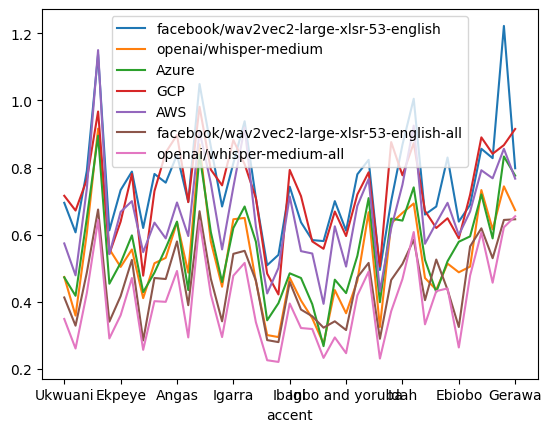

In [50]:
accent_df_[["facebook/wav2vec2-large-xlsr-53-english", 
            "openai/whisper-medium", "Azure", "GCP", "AWS", 
            "facebook/wav2vec2-large-xlsr-53-english-all", "openai/whisper-medium-all"]].plot()

In [51]:
combined_df = pd.concat([test_norm_df, test_norm_finetune_df])

ood_test_norm_accent_df =ood_accent_wer(combined_df, traindevset, 100, open_source, commercial, ours)
ood_test_norm_accent_df

79 108


,country,Samples,facebook/wav2vec2-large-xlsr-53-english,openai/whisper-medium,Azure,GCP,AWS,facebook/wav2vec2-large-xlsr-53-english-all,openai/whisper-medium-all
accent,,,,,,,,,
Ukwuani,[NG],119,0.649,0.364,0.393,0.677,0.484,0.329,0.244
Eggon,[NG],100,0.522,0.254,0.316,0.616,0.359,0.215,0.122
Mada,[NG],78,0.698,0.485,0.560,0.684,0.634,0.336,0.236
Bini,[NG],76,1.064,0.830,0.840,0.916,1.061,0.484,0.412
"Yoruba, hausa",[NG],75,0.538,0.462,0.367,0.463,0.437,0.209,0.133
Ekpeye,[NG],70,0.681,0.376,0.406,0.582,0.539,0.280,0.190
Mwaghavul,[NG],67,0.698,0.444,0.513,0.690,0.613,0.332,0.235
Bajju,[NG],61,0.534,0.229,0.323,0.428,0.378,0.204,0.171
Ikulu,[NG],60,0.692,0.406,0.388,0.650,0.543,0.296,0.195


In [52]:
langauge_family_df = pd.read_csv("../data/afrispeech_language_family.csv")
ood_test_norm_accent_df_ = ood_test_norm_accent_df.merge(langauge_family_df, on="accent").set_index("accent")



columns = ["family", "country", "Samples", 
            "facebook/wav2vec2-large-xlsr-53-english",
            "nvidia/stt-en-conformer-transducer-large",
            "openai/whisper-medium"]+commercial+["facebook/wav2vec2-large-xlsr-53-english-all",
            "nvidia/stt-en-conformer-transducer-large-all",
            "openai/whisper-medium-all"]

ood_test_norm_accent_df__ = bold_min_values(ood_test_norm_accent_df_, columns=open_source+commercial+ours)
ood_test_norm_accent_df__ = ood_test_norm_accent_df__.merge(ood_test_norm_accent_df_[["country", "family", "Samples"]], on="accent")

ood_test_norm_accent_df__["nvidia/stt-en-conformer-transducer-large"] = "-"
ood_test_norm_accent_df__["nvidia/stt-en-conformer-transducer-large-all"] = "-"
ood_test_norm_accent_df__ = ood_test_norm_accent_df__[columns]
ood_test_norm_accent_df__ = ood_test_norm_accent_df__.sort_values(["family", "Samples"], ascending=False)
ood_test_norm_accent_df__


,family,country,Samples,facebook/wav2vec2-large-xlsr-53-english,nvidia/stt-en-conformer-transducer-large,openai/whisper-medium,Azure,GCP,AWS,facebook/wav2vec2-large-xlsr-53-english-all,nvidia/stt-en-conformer-transducer-large-all,openai/whisper-medium-all
accent,,,,,,,,,,,,
Ukwuani,Niger-Congo,[NG],119,0.649,-,0.364,0.393,0.677,0.484,0.329,-,\textbf{0.244}
Eggon,Niger-Congo,[NG],100,0.522,-,0.254,0.316,0.616,0.359,0.215,-,\textbf{0.122}
Bini,Niger-Congo,[NG],76,1.064,-,0.830,0.840,0.916,1.061,0.484,-,\textbf{0.412}
"Yoruba, hausa",Niger-Congo,[NG],75,0.538,-,0.462,0.367,0.463,0.437,0.209,-,\textbf{0.133}
Ekpeye,Niger-Congo,[NG],70,0.681,-,0.376,0.406,0.582,0.539,0.28,-,\textbf{0.19}
Bajju,Niger-Congo,[NG],61,0.534,-,0.229,0.323,0.428,0.378,0.204,-,\textbf{0.171}
Ikulu,Niger-Congo,[NG],60,0.692,-,0.406,0.388,0.650,0.543,0.296,-,\textbf{0.195}
Jaba,Niger-Congo,[NG],59,0.699,-,0.462,0.475,0.798,0.529,0.343,-,\textbf{0.268}
Ekene,Niger-Congo,[NG],55,0.667,-,0.414,0.350,0.673,0.519,0.3,-,\textbf{0.192}


In [53]:
ood_test_norm_accent_df__ = ood_test_norm_accent_df__.drop(columns="family")
print(ood_test_norm_accent_df__.to_latex(escape=False))

\begin{tabular}{llrrlrrrrlll}
\toprule
{} & country &  Samples &  facebook/wav2vec2-large-xlsr-53-english & nvidia/stt-en-conformer-transducer-large &  openai/whisper-medium &  Azure &    GCP &    AWS & facebook/wav2vec2-large-xlsr-53-english-all & nvidia/stt-en-conformer-transducer-large-all & openai/whisper-medium-all \\
accent          &         &          &                                          &                                          &                        &        &        &        &                                             &                                              &                           \\
\midrule
Ukwuani         &    [NG] &      119 &                                    0.649 &                                        - &                  0.364 &  0.393 &  0.677 &  0.484 &                                       0.329 &                                            - &            \textbf{0.244} \\
Eggon           &    [NG] &      100 &                              